The project is intended to create new horoscopes using RNN.
First of all we need raw materials!
Even if we'll use a pre-trained NLP model, we need as much horoscopes as possible.
The best site we found was https://mystarshoroscopes.com/ 
It contains about 10000 horoscopes.

In [34]:
from fastai.text import * 
from bs4 import BeautifulSoup
import requests
import pandas as pd
import re
import csv
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats


In [ ]:
error_msg = "The page you are looking for no longer exists. Perhaps you can return back to the homepage and see if you can find what you are looking for. Or, you can try finding it by using the search form below."

signs = ["aries", "taurus", "gemini", "cancer", "leo", "virgo", "libra", 
         "scorpio", "sagittarius", "capricorn", "aquarius", "pisces"]
months = ["january", "february", "march", "april", "may", "june", "july", 
          "august", "september", "october", "november", "december"]

days = [str(day) for day in range(1, 32)]
    
years = ["2019", "2018", "2017", "2016"]

voc = "qwertyuiopasdfghjklzxcvbnmèòàùQWERTYUIOPASDFGHJKLZXCVBNM.,;?! "

We start by using requests module to request the html of the pages we are looking for.
With BeautifulSoup library and some basic knowledge of html it can be found the horoscope's text on each page.

In [ ]:
datas = []

for sign, month, day, year in zip(signs, months, days, years):
    try: 
        url = "https://mystarshoroscopes.com/" + sign + "-daily-horoscope-for-" \
                + month + "-" + day + "-" + year + "/"
        requests.get(url, verify=True)
        html = requests.get(url).text
        soup = BeautifulSoup(html, 'html5lib').find(class_ = "entry-content")
        if soup and soup.text != error_msg:
            datas.append((soup.text, sign, day + " " + month + " " + year))            
    except:
        pass

We store the datas using pandas' DataFrame and we finally convert it into csv

In [ ]:
df = pd.DataFrame(datas, columns = ['text', 'sign ', 'date']) 
export_csv = df.to_csv (r'C:\Users\Giuliano\Documents\GitHub\horoscope\horoscopes.csv', index = None, header=True)

Cleaning the text ...

In [ ]:
hor_csv = open("horoscopes.csv", encoding="utf8")
hor = pd.read_csv(hor_csv)
hor = hor.drop(columns = "date")
index = [i for i in range(0, len(hor))]

for i in index:
    text = hor["text"][i].strip()
    text_new = ""
    for char in text:
        if char in voc:
            text_new = text_new + char
    hor.xs(i)['text'] = text_new

export_csv = hor.to_csv (r'C:\Users\Giuliano\Documents\GitHub\horoscope\text_and_sign.csv', index = None, header=True)

In [ ]:
hor_csv = open("horoscopes.csv", encoding="utf8")
hor = pd.read_csv(hor_csv)
hor = hor.drop(columns = "date")
hor = hor.drop(columns = "sign")
index = [i for i in range(0, len(hor))]

for i in index:
    text = hor["text"][i].strip()
    text_new = ""
    for char in text:
        if char in voc:
            text_new = text_new + char
    hor.xs(i)['text'] = text_new

export_csv = hor.to_csv (r'C:\Users\Giuliano\Documents\GitHub\horoscope\textonly.csv', index = None, header=True)

And we are ready to try the fastai library!
The text module of the fastai library contains a pre-trained model for text-generation.
We can try it without fine-tuned the model and it produces well sentences, but not horoscopes... 
So, we need to train the model with our datas..

In [97]:
data_lm = TextLMDataBunch.from_csv('.', 'textonly.csv')
data_lm.save('data_lm_export.pkl')

In [98]:
# Load previous iteration of the model
path = 'C:/Users/Giuliano/Documents/GitHub/horoscope'
data_lm = load_data(path, 'data_lm_export.pkl')                                 
learn2 = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)
learn2.load_encoder('language_model')
learn2.unfreeze()


RuntimeError: Error(s) in loading state_dict for AWD_LSTM:
	size mismatch for encoder.weight: copying a param with shape torch.Size([7304, 400]) from checkpoint, the shape in current model is torch.Size([7320, 400]).
	size mismatch for encoder_dp.emb.weight: copying a param with shape torch.Size([7304, 400]) from checkpoint, the shape in current model is torch.Size([7320, 400]).

In [ ]:
# See if it's working
learn2.predict("Fabio is ", n_words=100)


In [ ]:
learn2.fit(1)


In [79]:
data_lm.save('data_lm_export.pkl')

Sometimes you are lucky with horoscopes and sometimes not.
Now, we want to predict if the horoscope brings you bad or good luck.
Even if it is easy to implement a quick-model from scratch, we use vaderSentiment library. 
This library uses a bag of words approach (a lookup table of positive and negative words) with some simple heuristics.
The advantage of this approach is that sentences containing negated positive words (e.g. “not happy”, “not good”) will still receive a negative sentence sentiment (thanks to the heuristics to flip the sentiment of the word following a negation).
Instead, a quick-model will just take the average of the sentiments of the words and would miss details like this.

In [31]:
analyser = SentimentIntensityAnalyzer()

def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    if score['compound'] > 0.3:
        print("That's great!")
    elif score['compound'] < - 0.3:
        print("That's a shame")
    else:
        print("Could be better...")

In [96]:
example = learn.predict("You will", n_words=100)

print(hor, "\n")

sentiment_analyzer_scores(hor)


You will n’t do do n’t do do do do do n’t n’t do know % n’t to do feel do buttons do schemes so scenes la curious scenes scenes electronic to scenes crushing fronts scenes zone ’ll feel scenes scenes % to attention to system scenarios big scenes scenes scenes hustle to to to feel to been to much hustle to statements to cabinets to map takes wo to big attention to to to to multi bubble scenes lifetime with in to buttons to dedication scenes so reflecting scenes dedication with light to fore takes number par hustle light doors closet 

Could be better...


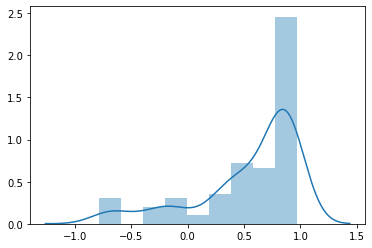

In [105]:
hor_csv = open(r'C:\Users\Giuliano\Documents\GitHub\horoscope\textonly.csv', encoding="utf8")

hor = pd.read_csv(hor_csv)
sent_arr = []

for i in index:
    score = analyser.polarity_scores(learn.predict(hor.iloc[i]['text']))
    sent_arr.append(score['compound'])

sns.distplot(sent_arr)

Using seaborn (a data visualization library) we plot an histogram of the horoscopes' luck.
As can be seen from the graph above, most of them are positive.
Now, we expect that our "new" horoscopes are positive, as well... And fortunately, that's true :)

[0.4877, -0.2263, 0.9338, 0.7003, 0.8074, 0.7589, 0.7893, -0.8126, 0.7579, -0.25, 0.6486, 0.9521, 0.7506, -0.3446, 0.8671, 0.128, 0.4019, 0.7498, -0.1027, 0.784, 0.2263, 0.7399, 0.34, 0.128, 0.1027, 0.128, 0.8042, 0.5994, 0.7096, 0.9118, 0.7351, 0.34, 0.3818, -0.4588, 0.0, 0.5719, -0.5106, 0.8074, -0.4939, 0.4939, 0.7635, 0.5267, 0.9634, -0.3182, 0.5254, 0.891, 0.8151, 0.3612, 0.25, 0.6705, 0.5574, 0.5859, 0.5859, 0.4939, 0.7402, 0.4019, 0.765, 0.6705, 0.9464, -0.5574, 0.2648, 0.7269, 0.6124, -0.5715, 0.8225, 0.8934, 0.5106, 0.2212, 0.9403, 0.7399, 0.6344, 0.836, 0.6249, 0.1372, 0.8323, 0.3744, 0.6249, 0.2732, 0.743, 0.8934, 0.0516, 0.2177, 0.4404, 0.3182, 0.128, 0.7076, 0.7003, 0.8519, 0.8316, 0.5777, 0.8348, 0.6457, 0.603, -0.2263, 0.7717, 0.3535, 0.0772, 0.25, 0.9203, 0.8402]


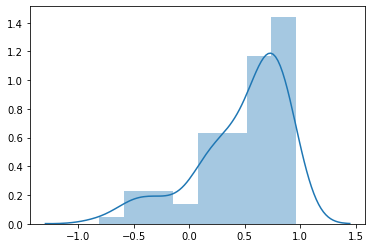

In [92]:
sent_arr = []
for _ in range(0, 100):
    score = analyser.polarity_scores(learn.predict("You will", n_words=100))
    sent_arr.append(score['compound'])

sns.distplot(sent_arr)

Now, we want to classify our "new" horoscopes by their signs.
We implement a naïve Bayes classifier from scratch.
It is a simple "probabilistic classifiers" based on applying Bayes' theorem with strong (naïve) independence assumptions between the features.
We use our datas to train it and then we can predict our new horoscopes. ( I should divide the training data into 2 parts to evaluate the accuracy. Buuut it can be low, soo maybe I won't show it in the real doc :( )

In [108]:
def prob_word_sign(sign, word):
    num_in = 0
    num_in_tot = 0
    for i in index:
        if hor.loc[i]['sign'] == sign:
            num_in_tot = num_in_tot + 1
            if word.lower() in hor.iloc[i]['text'].lower().split():
                num_in = num_in + 1
    p = (num_in + 1) / (num_in_tot + 2)
    return math.log(p)

def prob_sent(sent, sign):
    sum = 0
    for word in sent.split():
        sum = sum + prob_word_sign(sign, word)
    return sum

def sign_sent(sent):
    tuple = max((prob_sent(sent, sign), sign) for sign in signs)
    return tuple[1]


hor_csv = open(r'C:\Users\Giuliano\Documents\GitHub\horoscope\text_and_sign.csv', encoding="utf8")
hor = pd.read_csv(hor_csv)


print(sign_sent("Ggrrrr!!!! Feel like taking a risk in love? Or maybe you want to add a bit of uh, spice,  to your relationship. Then you’ll be pleased to know that amorous Venus enters your house of free-spirited thinking today. However, this isn’t just about being kinky, so stop thinking 50 Shades. This is more about taking exotic vacations together, dating a brand new type or going to new venues on date night."))

aries
